# Classificacao de SPAMs em mensagens SMS com Naive Bayes

Na aula, aprendeemos um pouco de extracao de features textuais (Vetorizacao), sobre Classificadores Naive Bayes e sobre metricas de avaliacao de classificadores.

A seguir, esta disponibilizado uma implementacao de um classificador de spams.

Dataset utilizado:

https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection


**Questao 1.** Altere a implementacao, de forma a utilizar TfidfVectorizer ao inves de CountVectorizer. Caso nao conheca TF-IDF, nao precisa estudar isso no momento, conversaremos sobre isso na proxima aula.

**Questao 2.** Com a base de treino, avalie diferentes classificadores Baysianos (lista de opcoes [neste link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes)) considerando a ROC-AUC como metrica. Por exemplo, voce pode definir essa metrica facilmente para realizacao de validacao cruzada:

cross_val_score(classifier, X_train, y_train, cv=custom_cv, scoring='roc_auc')

**Questao 3.** Escolha o melhor classificador da etapa anterior e observe sua Curva ROC (na base de teste). Qual ponto de operacao (threshold) quer parece evitar de forma rigorosa que uma mensagem autentica seja direcionada para a caixa de spam? Dica: para isso, voce deve refletir sobre qual seria a melhor classe para considerar como positiva e observar a sensitividade do modelo.



#### Imports

In [47]:
import requests
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay


#### Carga do Dataset

In [48]:
orig_url='https://drive.google.com/file/d/19qYhN6D7h65WBUdNMUsboyJv5qlQeNbh/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw, encoding = "ISO-8859-1")
df.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Pre-processamento

In [49]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [50]:
enc = OrdinalEncoder(dtype=np.int8)
df['label'] = enc.fit_transform(df[['label']].values)

## Datset Split

In [51]:
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [52]:
X_train.shape

(3900,)

In [53]:
X_test.shape

(1672,)

## Extracao de Features Textuais

### Questao 1 - Definindo o Vetorizador de Termos

In [54]:
# instanciando o vetorizador
tfidf = TfidfVectorizer(stop_words ='english')

# fit com os dados de treino
tfidf.fit(X_train)

TfidfVectorizer(stop_words='english')

In [55]:
tfidf.vocabulary_

{'review': 5158,
 'fantastic': 2523,
 'nokia': 4306,
 'gage': 2777,
 'game': 2784,
 'deck': 2007,
 'club': 1683,
 'www': 6808,
 'cnupdates': 1697,
 'com': 1726,
 'newsletter': 4275,
 'unsubscribe': 6400,
 'alerts': 833,
 'reply': 5106,
 'word': 6757,
 'just': 3490,
 'got': 2903,
 'outta': 4487,
 'class': 1657,
 'gonna': 2884,
 'gym': 2977,
 'coming': 1738,
 'friday': 2727,
 'leave': 3642,
 'pongal': 4738,
 'news': 4274,
 'work': 6759,
 'place': 4669,
 'hi': 3092,
 'dear': 1992,
 'urgnt': 6426,
 'don': 2187,
 'know': 3561,
 'whats': 6676,
 'problem': 4851,
 'want': 6586,
 'tell': 6037,
 'wating': 6610,
 'friend': 2731,
 'says': 5299,
 'upping': 6414,
 'order': 4458,
 'grams': 2921,
 'lt': 3813,
 'gt': 2957,
 'telly': 6041,
 'brdget': 1340,
 'jones': 3463,
 'yes': 6859,
 'saw': 5295,
 'message': 4004,
 'new': 4270,
 'voicemail': 6529,
 '08719181513': 146,
 'yesterday': 6861,
 'true': 6291,
 'thinking': 6112,
 'day': 1982,
 'great': 2936,
 'ok': 4402,
 'floppy': 2640,
 'snappy': 5603,
 'h

In [56]:
tfidf.get_feature_names_out()

array(['00', '000', '000pes', ..., 'zogtorius', 'zoom', 'zouk'],
      dtype=object)

## Transformando os Dados de Treino e Teste

In [57]:
X_train_transf = tfidf.transform(X_train)
X_test_transf = tfidf.transform(X_test)

## Treinando e executando o modelo

### Questao 02

In [58]:
# Ao usar validação cruzada não é necessário treinar, nem prever, pois ele já faz isso sozinho

scores_bern1 = cross_val_score(MultinomialNB(alpha=1.0), X_train_transf, y_train, cv=10, scoring='roc_auc')
scores_bern2 = cross_val_score(BernoulliNB(alpha=1.0), X_train_transf, y_train, cv=10, scoring='roc_auc')
scores_bern3 = cross_val_score(GaussianNB(), X_train_transf.toarray(), y_train, cv=10, scoring='roc_auc')

print("MultinomialNB", scores_bern1.mean())
print("BernoulliNB", scores_bern2.mean())
print("GaussianNB", scores_bern3.mean())


MultinomialNB 0.9901473414650948
BernoulliNB 0.9933801736922231
GaussianNB 0.8863168620666693


### Questao 03

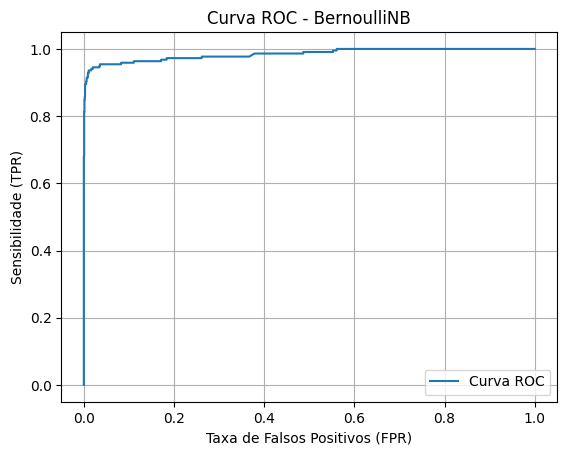

In [59]:
model = BernoulliNB(alpha=1.0)
model.fit(X_train_transf, y_train)

y_pred_prob = model.predict_proba(X_test_transf)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob[:,1])

plt.plot(false_positive_rate, true_positive_rate, label="Curva ROC")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Sensibilidade (TPR)")
plt.title("Curva ROC - BernoulliNB")
plt.legend()
plt.grid()
plt.show()


In [72]:
for fpr, tpr, thr in zip(false_positive_rate, true_positive_rate, thresholds):
    if fpr < 0.01:
        print(f"Threshold: {thr:.3f} | FPR: {fpr:.3f} | TPR: {tpr:.3f}")


Threshold: inf | FPR: 0.000 | TPR: 0.000
Threshold: 1.000 | FPR: 0.000 | TPR: 0.219
Threshold: 1.000 | FPR: 0.000 | TPR: 0.237
Threshold: 1.000 | FPR: 0.000 | TPR: 0.247
Threshold: 1.000 | FPR: 0.000 | TPR: 0.251
Threshold: 1.000 | FPR: 0.000 | TPR: 0.279
Threshold: 1.000 | FPR: 0.000 | TPR: 0.292
Threshold: 1.000 | FPR: 0.000 | TPR: 0.301
Threshold: 1.000 | FPR: 0.000 | TPR: 0.374
Threshold: 1.000 | FPR: 0.000 | TPR: 0.393
Threshold: 1.000 | FPR: 0.000 | TPR: 0.438
Threshold: 1.000 | FPR: 0.000 | TPR: 0.447
Threshold: 1.000 | FPR: 0.000 | TPR: 0.548
Threshold: 1.000 | FPR: 0.000 | TPR: 0.557
Threshold: 1.000 | FPR: 0.000 | TPR: 0.653
Threshold: 1.000 | FPR: 0.000 | TPR: 0.662
Threshold: 1.000 | FPR: 0.000 | TPR: 0.680
Threshold: 1.000 | FPR: 0.001 | TPR: 0.680
Threshold: 0.672 | FPR: 0.001 | TPR: 0.763
Threshold: 0.661 | FPR: 0.001 | TPR: 0.772
Threshold: 0.054 | FPR: 0.001 | TPR: 0.813
Threshold: 0.036 | FPR: 0.001 | TPR: 0.813
Threshold: 0.028 | FPR: 0.001 | TPR: 0.817
Threshold: 0.

 Para evitar rigorosamente que uma mensagem autêntica (HAM) seja enviada incorretamente para a caixa de spam, vale a pena tratar mensagens HAM como a classe positiva. Dessa forma, podemos focar em maximizar a sensibilidade (TPR) para sms legítimos, ou seja, garantir que o maior número possível delas seja corretamente identificado. Um bom threshold seria 0.661, com FPR extremamente baixo de 0.001 e um TPR bom, considerando o trade-off, de 0.772.